In [2]:
import pandas as pd
import numpy as np
import os
from os import getcwd
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
dateparser = lambda x: pd.datetime.strptime(x, "%Y-%m-%d")

df = pd.read_csv(getcwd()+"\\Stocks\\a.us.txt", parse_dates=['Date'], date_parser=dateparser)

In [5]:
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,1999-11-18,30.713,33.754,27.002,29.702,66277506,0
1,1999-11-19,28.986,29.027,26.872,27.257,16142920,0
2,1999-11-22,27.886,29.702,27.044,29.702,6970266,0
3,1999-11-23,28.688,29.446,27.002,27.002,6332082,0
4,1999-11-24,27.083,28.309,27.002,27.717,5132147,0


In [6]:
len(df)

4521

# Goal: predict High(t) given last 20 High

In [69]:
data = df[['High']]

In [70]:
data.head()

,High
0,33.754
1,29.027
2,29.702
3,29.446
4,28.309


In [13]:
# change time series data into supervised dataset looking back n_past number of points
def create_datasets(series, n_past):
    data = []
    target = []
    
    for i in range(len(series) - n_past - 1):
        
        indicies = range(i,n_past+i)
        
        data.append(series[indicies])
        target.append(series[n_past+i])

    
    return np.array(data), np.array(target)

In [14]:
# randomize data + target together along axis=0
def randomize_data(data, target):
    tmp = np.concatenate((data, target), axis=1)
    
    np.random.seed(101)
    np.random.shuffle(tmp)
    
    tmp_data = tmp[:, :-1]
    tmp_target = tmp[:, -1]
    
    return tmp_data, tmp_target

In [66]:
window_size = 20

data, target = create_datasets(data.values, window_size)

In [67]:
data.shape, target.shape

((4500, 20, 1), (4500, 1))

In [37]:
data = data.reshape((data.shape[0], window_size))
data, target = randomize_data(data, target)
data.shape, target.shape

((4500, 20), (4500,))

In [38]:
target = target.reshape((target.shape[0], 1))

In [39]:
TRAIN_SPLIT = int(data.shape[0] * 0.8)

In [40]:
from sklearn.preprocessing import MinMaxScaler

In [41]:
scaler_data = MinMaxScaler()
scaler_target = MinMaxScaler()

In [42]:
x_train = data[:TRAIN_SPLIT]
x_val = data[TRAIN_SPLIT:]

y_train = target[:TRAIN_SPLIT]
y_val = target[TRAIN_SPLIT:]

In [43]:
x_train = scaler_data.fit_transform(x_train)
x_val = scaler_data.transform(x_val)

In [44]:
y_train = scaler_target.fit_transform(y_train)
y_val = scaler_target.transform(y_val)

In [45]:
x_train[0]

array([0.33711251, 0.32646155, 0.32263262, 0.31985419, 0.32175308,
       0.31928476, 0.31478999, 0.31436235, 0.31210796, 0.31646974,
       0.31448556, 0.31364935, 0.30543188, 0.30714017, 0.30704199,
       0.31147658, 0.32367195, 0.309035  , 0.30848521, 0.31303205])

In [46]:
x_train.shape

(3600, 20)

In [47]:
x_train = x_train.reshape((TRAIN_SPLIT, window_size, 1))
x_val = x_val.reshape((len(data) - TRAIN_SPLIT, window_size, 1))

In [48]:
y_train.shape, y_val.shape

((3600, 1), (900, 1))

In [49]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size, input_shape=(window_size, 1), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(window_size)),
    tf.keras.layers.Dense(units=20, activation='relu'),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

model.compile(optimizer='adam', loss='mae')

history = model.fit(x=x_train, y=y_train, epochs=50, validation_data=(x_val, y_val), verbose=2)

Epoch 1/50
113/113 - 2s - loss: 0.0525 - val_loss: 0.0208
Epoch 2/50
113/113 - 1s - loss: 0.0137 - val_loss: 0.0123
Epoch 3/50
113/113 - 1s - loss: 0.0122 - val_loss: 0.0099
Epoch 4/50
113/113 - 1s - loss: 0.0119 - val_loss: 0.0123
Epoch 5/50
113/113 - 1s - loss: 0.0099 - val_loss: 0.0094
Epoch 6/50
113/113 - 1s - loss: 0.0097 - val_loss: 0.0082
Epoch 7/50
113/113 - 1s - loss: 0.0097 - val_loss: 0.0108
Epoch 8/50
113/113 - 1s - loss: 0.0095 - val_loss: 0.0085
Epoch 9/50
113/113 - 1s - loss: 0.0090 - val_loss: 0.0075
Epoch 10/50
113/113 - 1s - loss: 0.0089 - val_loss: 0.0073
Epoch 11/50
113/113 - 1s - loss: 0.0084 - val_loss: 0.0078
Epoch 12/50
113/113 - 1s - loss: 0.0084 - val_loss: 0.0071
Epoch 13/50
113/113 - 1s - loss: 0.0085 - val_loss: 0.0081
Epoch 14/50
113/113 - 1s - loss: 0.0085 - val_loss: 0.0093
Epoch 15/50
113/113 - 1s - loss: 0.0082 - val_loss: 0.0070
Epoch 16/50
113/113 - 1s - loss: 0.0075 - val_loss: 0.0063
Epoch 17/50
113/113 - 1s - loss: 0.0074 - val_loss: 0.0068
Epoch 

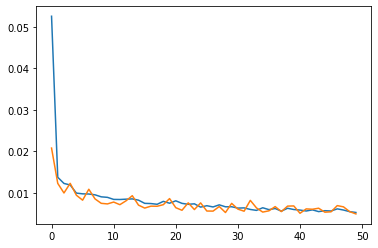

In [51]:
epochs = range(len(history.history['loss']))
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])

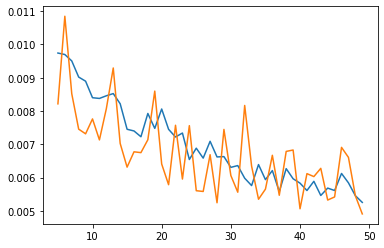

In [58]:
plt.plot(epochs[5:], history.history['loss'][5:])
plt.plot(epochs[5:], history.history['val_loss'][5:])

In [54]:
# helper functions included from tensorflow.org
def create_time_steps(length):
  return list(range(-length, 0))

def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

In [56]:
def make_plot_forecast(model, inputs, target, indx):
    preds = model.predict(inputs)
    
    plot = show_plot([inputs[indx], target[indx],
                    preds[indx]], 0, 'Simple LSTM model')
    plot.show()

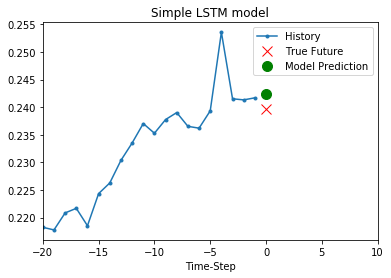

In [57]:
make_plot_forecast(model, x_val, y_val, 10)

In [59]:
def multi_step_forecast(model, inputs, target, indx, n_past, n_future):
    forecast = []

    x_input = inputs[indx].reshape((1, inputs.shape[1], inputs.shape[2]))
        
    for i in range(n_future):
        
        pred = model.predict(x_input)
        tmp = x_input.reshape((n_past))
        tmp = np.append(tmp[1:], pred[0][0])
        x_input = tmp.reshape((1, n_past, 1))
        
        forecast.append(pred[0][0])
    
    return forecast

forecast = multi_step_forecast(model, x_val, y_val, 0, window_size, 2)        

In [60]:
x_val.shape, y_val.shape

((900, 20, 1), (900, 1))

In [61]:
x_val[0].shape, y_val[0].shape

((20, 1), (1,))

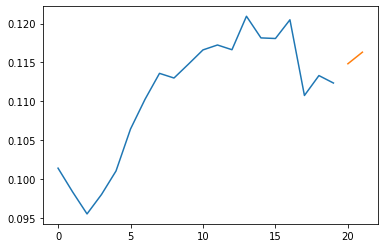

In [62]:
def plot_multi_forecast(inputs, target, forecast, indx):
    
    input_val = inputs[indx].reshape(inputs.shape[1])
    input_x = range(len(input_val))

    plt.plot(input_x, input_val)

    forecast_x = range(len(input_val), len(input_val) + len(forecast))
    
    plt.plot(forecast_x, forecast)
    
plot_multi_forecast(x_val, y_val, forecast, 0)